# NSF Computer and Information Science and Engineering (CISE) 

- `0505****`: Division of Computer and Network Systems (CNS)
- `0501****`: Division of Computing and Communication Foundations (CCF)
- `0502****`: Division of Information and Intelligent Systems (IIS)
- `0509****`: Office of Advanced Cyberinfrastructure (OAC)

In [1]:
import os,sys,json
import core.coworknet, core.nsf_utils
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import networkx as nx
import seaborn as sns
import pandas as pd
from datetime import datetime
from collections import Counter

In [2]:
grant_type = ["Standard Grant", "Continuing grant"] # draw only these types
div_type = {
    "0505": "Division of Computer and Network Systems (CNS)",
    "0501": "Division of Computing and Communication Foundations (CCF)",
    "0502": "Division of Information and Intelligent Systems (IIS)",
    "0509": "Office of Advanced Cyberinfrastructure (OAC)"
}

In [3]:
def histogram_num_pis(data, years, orgcodes):
    plt.title("[NSF {}-{}] histogram - number of PIs".format(years[0], years[-1]))
    plt.ylabel("Number of grants")
    plt.xlabel("Number of PIs")
    pis = [d["num_pis"] for d in data.values() if d["org"][:4] in orgcodes]
    counter_pis = Counter(pis)
    print(counter_pis)
    x = range(1, 10)
    y = [counter_pis[i] if i in counter_pis else 0 for i in x]
    plt.bar(x, y)

In [4]:
data = {}
years = [2004]
for y in years:
    data.update(core.nsf_utils.load_numpub_data(y))
data = {k:v for k, v in data.items() if v["type"] in grant_type}
for y in years:
    print("[{}]".format(y))
    print("Total number of grants", len([v for v in data.values() if v["year"] == y]))
    for code, desc in div_type.items():
        print(desc, len([v for v in data.values() if v["org"][:4] == code and v["year"] == y]))

[2004]
Total number of grants 10212
Division of Computer and Network Systems (CNS) 413
Division of Computing and Communication Foundations (CCF) 349
Division of Information and Intelligent Systems (IIS) 365
Office of Advanced Cyberinfrastructure (OAC) 53


Counter({1: 653, 2: 246, 3: 125, 5: 84, 4: 63, 6: 4, 0: 2, 7: 2, 8: 1})


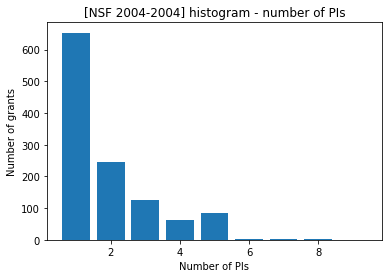

In [5]:
histogram_num_pis(data, years, div_type.keys())

In [6]:
grant_list = [k for k, d in data.items() if d["org"][:4] in div_type.keys() and d["num_pis"] == 2]
print(grant_list)

['0401049', '0403020', '0403130', '0403590', '0404001', '0404011', '0404193', '0404297', '0404440', '0406305', '0406345', '0406384', '0410203', '0410246', '0410409', '0410524', '0410553', '0410771', '0410790', '0410918', '0410937', '0411127', '0411152', '0411307', '0412029', '0412858', '0412884', '0412894', '0412930', '0412965', '0413012', '0413078', '0413085', '0413138', '0413196', '0413214', '0413227', '0413251', '0413284', '0413321', '0413328', '0413709', '0414380', '0414409', '0414482', '0414557', '0414567', '0414630', '0414710', '0414762', '0414763', '0414791', '0414815', '0414976', '0414981', '0415016', '0415021', '0415101', '0415175', '0415195', '0415257', '0415865', '0415923', '0416364', '0417607', '0418165', '0420337', '0420434', '0420505', '0420866', '0420873', '0420906', '0420985', '0423014', '0423039', '0423070', '0423253', '0423305', '0423546', '0423584', '0424601', '0426021', '0426557', '0426627', '0426674', '0426879', '0426904', '0427260', '0427385', '0427695', '0428427'

In [7]:
grant_list = [k for k, d in data.items() if d["org"][:4] in div_type.keys() and d["num_pis"] == 2]
print(len(grant_list), "grants with 2 PIs")

246 grants with 2 PIs


In [8]:
no_publications = []
no_edges = []
other = []
only_one_pi = []
two_separate = []
two_cowork = []
for pid in grant_list:
    award, table, ts, te, G_all = core.coworknet.get_grant_coworknet_pis(pid)
    if len(table) == 0:
        no_publications.append(pid)
        continue
    pis = [a for a in G_all.nodes() if "pi" in G_all.nodes[a] and G_all.nodes[a] ["pi"]]
    G = G_all.subgraph(pis)
        
    working_pis = []
    reported_pub_number = 0
    for k, v in table.items():
        if v["type"]: # only count publicatoins in-grant
            reported_pub_number += 1
            working_pis.append([a for a, av in v["authors"].items() if av["pi"]])
    # print(pid, working_pis)
    pi_counter = [set([n[0]+n.split(" ")[-1] for n in group]) for group in working_pis]
    pi_union = set.union(*pi_counter)
    pi_max_group = max([len(pg) for pg in pi_counter])
#     print(pi_counter, pi_union, pi_max_group)
    print("{} union={}, max_group={}, numpub={} {} {}".format(pid, len(pi_union), pi_max_group, reported_pub_number, len(table), len(G.edges)))
    if len(pi_union) == 2 and pi_max_group == 2:
        two_cowork.append(pid)
    elif len(pi_union) == 2:
        two_separate.append(pid)
    elif len(pi_union) == 1:
        only_one_pi.append(pid)
    else:
        other.append(pid)
print("{} ({:.2f}%) grants have no publication".format(len(no_publications), 100*len(no_publications)/len(grant_list)))
print("{} ({:.2f}%) grants have only one working PI".format(len(only_one_pi), 100*len(only_one_pi)/len(grant_list)))
print("{} ({:.2f}%) grants have two PIs working separately".format(len(two_separate), 100*len(two_separate)/len(grant_list)))
print("{} ({:.2f}%) grants have two PIs collaborated".format(len(two_cowork), 100*len(two_cowork)/len(grant_list)))
print("{} ({:.2f}%) grants are unknown".format(len(other), 100*len(other)/len(grant_list)))

0401049 union=2, max_group=2, numpub=1 25 25
0404001 union=1, max_group=1, numpub=3 3 0
0404011 union=2, max_group=2, numpub=4 8 6
0404297 union=2, max_group=2, numpub=3 6 5
0406305 union=2, max_group=2, numpub=2 8 7
0406345 union=2, max_group=1, numpub=11 11 0
0410203 union=2, max_group=2, numpub=19 19 1
0410246 union=2, max_group=2, numpub=15 18 4
0410409 union=2, max_group=2, numpub=5 5 1
0410553 union=2, max_group=2, numpub=8 9 3
0410771 union=2, max_group=2, numpub=9 9 3
0410790 union=1, max_group=1, numpub=2 2 0
0410918 union=2, max_group=2, numpub=18 25 12
0410937 union=2, max_group=2, numpub=19 40 27
0411127 union=2, max_group=2, numpub=64 94 41
0411152 union=2, max_group=2, numpub=13 22 11
0411307 union=2, max_group=2, numpub=6 33 29
0412029 union=1, max_group=1, numpub=3 3 0
0412884 union=2, max_group=1, numpub=10 10 0
0412894 union=1, max_group=1, numpub=7 7 0
0412930 union=2, max_group=2, numpub=14 14 1
0412965 union=0, max_group=0, numpub=1 1 0
0413012 union=2, max_group=2

In [9]:
collab_type = {}
dict_period = {}
dict_amount = {}
dict_teams = {}
dict_publications = {}
dict_citations = {}
dict_timestamps = {}
convert_t = lambda t: datetime.strptime(t, "%Y-%m-%dT%X")

for grant_id in grant_list:
    award,_,ts,te,G_all = core.coworknet.get_grant_coworknet_pis(grant_id)
    pis = [a for a in G_all.nodes() if "pi" in G_all.nodes[a] and G_all.nodes[a] ["pi"]]
#     print(pis)
    G = G_all.subgraph(pis)
#     if len(G.edges) == 0:
#         continue
        
#     print(grant_id)
    publications = {"pre-grant":0, "grant":0, "post-grant":0}
    citations = {"pre-grant":0, "grant":0, "post-grant":0}
    teams = {"pre-grant":0, "grant":0, "post-grant":0}
    dates = [convert_t(data["date"]) for _,_,data in G.edges.data()]
    for u,v,data in G.edges.data():
#         print(data["paper"])
        coauthor = set()
        for e in G_all.edges.data():
            if e[2]["paper"] == data["paper"]:
                coauthor.update([e[0], e[1]])
        num_coauthor = len(coauthor)
#         print(data["paper"], num_coauthor)
        print(grant_id, data["paper"], num_coauthor)
        
#         print(data["paper"], num_coauthor)
        if data["grant"] != "other" or (ts <= convert_t(data["date"]) and convert_t(data["date"]) <= te):
#             print("grant") # reported publications or unreported pubs in the grant period
            teams["grant"] += num_coauthor
            publications["grant"] += 1
            citations["grant"] += data["citation"]
        elif convert_t(data["date"]) < ts:
#             print("pre-grant") # unreported publications before the grant period
            teams["pre-grant"] += num_coauthor
            publications["pre-grant"] += 1
            citations["pre-grant"] += data["citation"]
        elif te < convert_t(data["date"]):
#             print("post-grant") # unreported publications after the grant period
            teams["post-grant"] += num_coauthor
            publications["post-grant"] += 1
            citations["post-grant"] += data["citation"]
    dict_period[grant_id] = (te-ts).days
    dict_amount[grant_id] = award["awardAmount"]
    dict_teams[grant_id] = teams
    dict_publications[grant_id] = publications
    dict_citations[grant_id] = citations
    dict_timestamps[grant_id] = sorted(dates)
#     print(publications, dict_timestamps[grant_id])

ctypes = []
for gid, v in dict_publications.items():
    collab_type[gid] = "{}{}{}".format(1 if v["pre-grant"]>0 else 0, 1 if v["grant"]>0 else 0, 1 if v["post-grant"]>0 else 0)
    ctypes.append(collab_type[gid])

print(len([k for k in dict_timestamps.keys() if collab_type[k] != "000"]), "grants - two PIs collaborated")
print(Counter(ctypes))

0401049 2761510018 5
0401049 2899168325 5
0401049 2763328646 5
0401049 2476491145 2
0401049 87762002 10
0401049 2128027218 6
0401049 2007385877 4
0401049 1480187351 2
0401049 2117218135 4
0401049 2098291930 5
0401049 2128410140 13
0401049 2043166365 7
0401049 200070492 2
0401049 2134792924 4
0401049 2127376416 5
0401049 2172825250 14
0401049 2089017767 3
0401049 2023566760 11
0401049 1216923629 7
0401049 1573865009 3
0401049 2134834993 4
0401049 1498631091 11
0401049 2147741811 5
0401049 164365427 8
0401049 2103128566 9
0404011 2172569416 2
0404011 2141039988 5
0404011 1493943414 4
0404011 2532343353 5
0404011 1989596475 3
0404011 1993251483 3
0404297 2599364901 5
0404297 1548079979 5
0404297 1993760683 5
0404297 188386583 5
0404297 2098491294 5
0406305 2106930560 4
0406305 2507666912 3
0406305 2166767458 5
0406305 2076676914 5
0406305 1986843240 7
0406305 2097791657 5
0406305 2156697773 3
0410203 2507902825 3
0410246 80472130 3
0410246 2040308490 4
0410246 2150315571 3
0410246 2327590

0415021 256536324 3
0415021 2158325515 4
0415021 2089348887 6
0415021 2396366106 3
0415021 2129993754 4
0415021 2169444776 5
0415021 2148286641 11
0415021 2168995909 9
0415021 2126200140 5
0415021 21382734 4
0415021 2102118225 9
0415021 2103592412 2
0415021 2125200094 4
0415021 2104499423 5
0415021 2019087967 14
0415021 169945183 4
0415021 2120309221 14
0415021 2612280934 2
0415021 2104779640 4
0415195 188145618 5
0415195 2500964445 3
0415195 2011804594 3
0415195 1490424579 4
0415257 2777524230 3
0415257 2617342730 3
0415257 37570443 4
0415257 2004188181 5
0415257 2339225884 3
0415257 1988615847 3
0415257 2028980140 3
0415257 50675760 2
0415257 2803875894 4
0415257 2086219721 4
0415257 205402838 3
0415257 2073566426 3
0415257 2043636189 3
0415257 279525992 4
0415257 2001995757 4
0415257 2125252087 4
0415257 72456441 3
0415257 2163133050 4
0415257 2075536383 3
0415865 2169384404 6
0415865 2119187236 4
0418165 2130622458 5
0420434 2478687318 3
0420906 2438574248 4
0423014 117376001 4
042

0430781 1975303279 6
0430781 2089732905 10
0430781 2040933249 4
0430781 1995297249 12
0430849 2154937603 4
0430849 2017619076 5
0430849 2584609412 7
0430849 2121573131 3
0430849 2105401484 7
0430849 850972942 4
0430849 1540575502 4
0430849 829689105 7
0430849 2116792850 3
0430849 2056536338 4
0430849 1553603221 4
0430849 1529661724 5
0430849 2903170972 7
0430849 1620667300 5
0430849 1528159271 3
0430849 2085562535 14
0430849 2000242599 3
0430849 2784219559 6
0430849 2734499628 7
0430849 2099898669 14
0430849 2162649143 3
0430849 1600867257 7
0430849 2064761790 7
0430849 2174643652 9
0430849 2405711304 7
0430849 2134710090 6
0430849 2169705039 8
0430849 2030754129 6
0430849 2180211925 5
0430849 2178552022 10
0430849 2150122711 6
0430849 53912917 4
0430849 2024503255 6
0430849 2074574297 8
0430849 2104947808 8
0430849 2069358561 7
0430849 2898845797 8
0430849 2137457770 3
0430849 2766893803 7
0430849 1587165042 7
0430885 87392896 4
0430885 2697326336 3
0430885 2101227906 4
0430885 241493

0435247 1979294498 5
0435247 2123492772 5
0435247 1980094218 3
0435247 2048855920 4
0435247 2111679633 3
0435247 260556785 4
0435247 2082773812 4
0435247 2004968765 3
0435247 2037415870 3
0435247 1991357351 3
0435272 2111451563 4
0435272 1966621853 6
0435272 2284876990 3
0435272 2141760382 3
0435272 2012253736 3
0435272 1496706313 4
0435303 2143756451 3
0435303 2105413189 4
0435303 1710235590 3
0435303 2089770759 3
0435303 2158794280 3
0435303 1899342455 3
0435303 2153450930 3
0435303 2077719959 3
0435303 1919494327 3
0435303 2293342462 3
0435303 2135647263 3
0435303 2246978295 3
0435303 2136848335 4
0435505 2047977378 3
0435505 2126449801 4
0435505 2091072140 4
0435505 2145967148 3
0435505 2131894414 4
0435505 1589949070 5
0435505 2112759983 4
0435505 2017751697 4
0435505 2138325452 3
0435505 2169896918 4
0435505 1600565850 4
0435505 2129783551 3
0435517 206230417 2
0435517 2269386376 6
0435517 2109824073 4
0435517 2144017041 3
0435517 2122734354 3
0435517 2081164438 5
0435517 1984309

0455998 1642889612 11
0455998 2088063089 3
0455998 1627146914 10
0455998 2008860748 3
0455998 2241663278 10
0455998 1984838926 3
117 grants - two PIs collaborated
Counter({'000': 129, '111': 50, '010': 26, '110': 22, '011': 19})


In [10]:
for grant_id in two_separate:
    award,_,ts,te,G_all = core.coworknet.get_grant_coworknet_pis(grant_id)
    pis = [a for a in G_all.nodes() if "pi" in G_all.nodes[a] and G_all.nodes[a] ["pi"]]
#     print(pis)
#     print(grant_id)
    publications = {"pre-grant":0, "grant":0, "post-grant":0}
    citations = {"pre-grant":0, "grant":0, "post-grant":0}
    teams = {"pre-grant":0, "grant":0, "post-grant":0}
    dates = [convert_t(data["date"]) for _,_,data in G.edges.data()]
    for u,v,data in G_all.edges.data():
#         print(data["paper"])
        if u in pis or v in pis:
            coauthor = set()
            for e in G_all.edges.data():
                if e[2]["paper"] == data["paper"]:
                    coauthor.update([e[0], e[1]])
            num_coauthor = len(coauthor)
            if data["grant"] != "other" or (ts <= convert_t(data["date"]) and convert_t(data["date"]) <= te):
                teams["grant"] += num_coauthor
                publications["grant"] += 1
                citations["grant"] += data["citation"]
            elif convert_t(data["date"]) < ts:
                teams["pre-grant"] += num_coauthor
                publications["pre-grant"] += 1
                citations["pre-grant"] += data["citation"]
            elif te < convert_t(data["date"]):
                teams["post-grant"] += num_coauthor
                publications["post-grant"] += 1
                citations["post-grant"] += data["citation"]
    dict_period[grant_id] = (te-ts).days
    dict_amount[grant_id] = award["awardAmount"]
    dict_teams[grant_id] = teams
    dict_publications[grant_id] = publications
    dict_citations[grant_id] = citations
    dict_timestamps[grant_id] = sorted(dates)
#     print(publications, dict_timestamps[grant_id])

for gid in two_separate:
    collab_type[gid] = "two_separate" 
    ctypes.append(collab_type[gid])
    
print(Counter(ctypes))

Counter({'000': 129, '111': 50, '010': 26, '110': 22, 'two_separate': 20, '011': 19})


In [11]:
for grant_id in only_one_pi:
    award,_,ts,te,G_all = core.coworknet.get_grant_coworknet_pis(grant_id)
    pis = [a for a in G_all.nodes() if "pi" in G_all.nodes[a] and G_all.nodes[a] ["pi"]]
#     print(pis)
#     print(grant_id)
    publications = {"pre-grant":0, "grant":0, "post-grant":0}
    citations = {"pre-grant":0, "grant":0, "post-grant":0}
    teams = {"pre-grant":0, "grant":0, "post-grant":0}
    dates = [convert_t(data["date"]) for _,_,data in G.edges.data()]
    for u,v,data in G_all.edges.data():
#         print(data["paper"])
        if u in pis or v in pis:
            coauthor = set()
            for e in G_all.edges.data():
                if e[2]["paper"] == data["paper"]:
                    coauthor.update([e[0], e[1]])
            num_coauthor = len(coauthor)
            if data["grant"] != "other" or (ts <= convert_t(data["date"]) and convert_t(data["date"]) <= te):
                teams["grant"] += num_coauthor
                publications["grant"] += 1
                citations["grant"] += data["citation"]
            elif convert_t(data["date"]) < ts:
                teams["pre-grant"] += num_coauthor
                publications["pre-grant"] += 1
                citations["pre-grant"] += data["citation"]
            elif te < convert_t(data["date"]):
                teams["post-grant"] += num_coauthor
                publications["post-grant"] += 1
                citations["post-grant"] += data["citation"]
    dict_period[grant_id] = (te-ts).days
    dict_amount[grant_id] = award["awardAmount"]
    dict_teams[grant_id] = teams
    dict_publications[grant_id] = publications
    dict_citations[grant_id] = citations
    dict_timestamps[grant_id] = sorted(dates)
#     print(publications, dict_timestamps[grant_id])

for gid in only_one_pi:
    collab_type[gid] = "only_one_pi" 
    ctypes.append(collab_type[gid])
    
print(Counter(ctypes))

Counter({'000': 129, '111': 50, 'only_one_pi': 46, '010': 26, '110': 22, 'two_separate': 20, '011': 19})


In [12]:
set([k for k in dict_timestamps.keys() if collab_type[k] not in ["000", "only_one_pi", "two_separate"]])-set(two_cowork)

{'0429631', '0434996'}

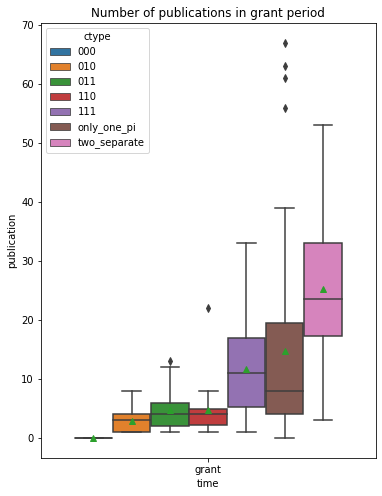

In [13]:
x = ["grant"]
ctype = ["000", "010", "011", "110", "111", "only_one_pi", "two_separate"]
box_plot_data = pd.DataFrame({
    "time": [time for time in x for k, v in collab_type.items() if v in ctype],
    "grant_amount": [dict_amount[k] for k, v in collab_type.items() if v in ctype],
    "grant_period": [dict_period[k] for k, v in collab_type.items() if v in ctype],
    "avg_team": [dict_teams[k][time]/dict_publications[k][time] if dict_publications[k][time] > 0 else 0 for time in x for k, v in collab_type.items() if v in ctype],
    "publication": [dict_publications[k][time] for time in x for k, v in collab_type.items() if v in ctype],
    "citation": [dict_citations[k][time] for time in x for k, v in collab_type.items() if v in ctype],
    "ctype": [v for time in x for k, v in collab_type.items() if v in ctype]
})
     
# print(box_plot_data.head(5))
plt.figure(figsize=(6,8))
ax = sns.boxplot(x="time", y="publication", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype).set_title("Number of publications in grant period")

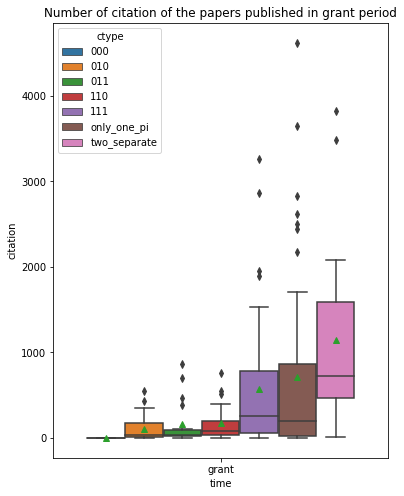

In [14]:
plt.figure(figsize=(6,8))
ax = sns.boxplot(x="time", y="citation", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype).set_title("Number of citation of the papers published in grant period")

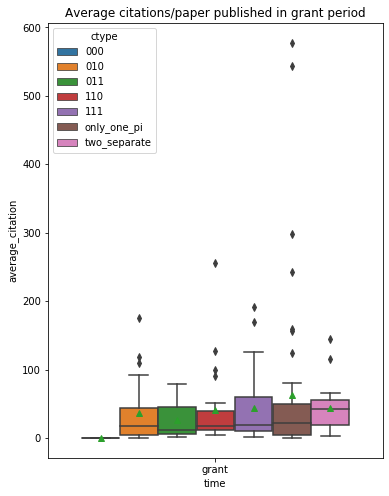

In [15]:
box_plot_data["average_citation"] = (box_plot_data["citation"]/box_plot_data["publication"]).fillna(0)
plt.figure(figsize=(6,8))
ax = sns.boxplot(x="time", y="average_citation", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype).set_title("Average citations/paper published in grant period")

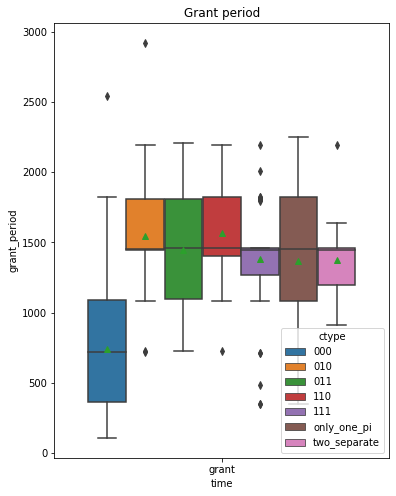

In [16]:
plt.figure(figsize=(6,8))
ax = sns.boxplot(x="time", y="grant_period", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype).set_title("Grant period")

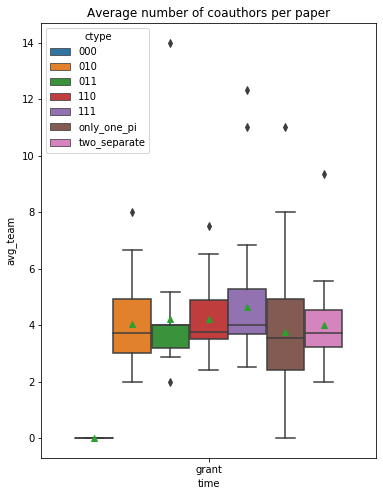

In [17]:
plt.figure(figsize=(6,8))
ax = sns.boxplot(x="time", y="avg_team", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype).set_title("Average number of coauthors per paper")

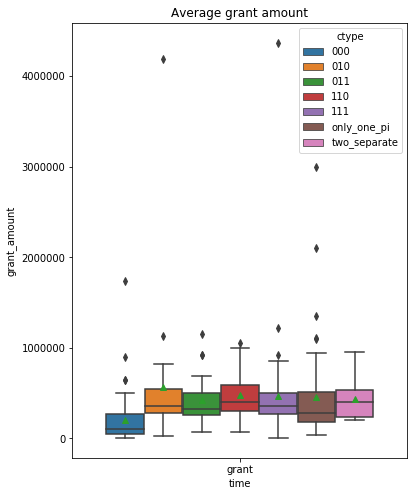

In [18]:
plt.figure(figsize=(6,8))
ax = sns.boxplot(x="time", y="grant_amount", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype).set_title("Average grant amount")

In [19]:
data = {}
years = [2009]
for y in years:
    data.update(core.nsf_utils.load_numpub_data(y))
data = {k:v for k, v in data.items() if v["type"] in grant_type}
for y in years:
    print("[{}]".format(y))
    print("Total number of grants", len([v for v in data.values() if v["year"] == y]))
    for code, desc in div_type.items():
        print(desc, len([v for v in data.values() if v["org"][:4] == code and v["year"] == y]))

[2009]
Total number of grants 14758
Division of Computer and Network Systems (CNS) 733
Division of Computing and Communication Foundations (CCF) 535
Division of Information and Intelligent Systems (IIS) 627
Office of Advanced Cyberinfrastructure (OAC) 193


Counter({1: 1258, 2: 457, 3: 174, 5: 93, 4: 83, 6: 15, 7: 4, 8: 2, 0: 2})


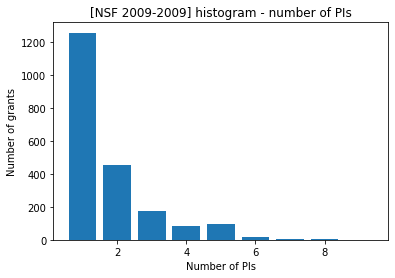

In [20]:
histogram_num_pis(data, years, div_type.keys())

In [21]:
grant_list = [k for k, d in data.items() if d["org"][:4] in div_type.keys() and d["num_pis"] == 2]
print(len(grant_list), "grants with 2 PIs")

457 grants with 2 PIs


In [22]:
grant_list

['0902885',
 '0903191',
 '0903384',
 '0903430',
 '0903432',
 '0903437',
 '0903447',
 '0903513',
 '0903549',
 '0904116',
 '0904338',
 '0904353',
 '0904361',
 '0904431',
 '0904449',
 '0904482',
 '0904501',
 '0904549',
 '0904572',
 '0904597',
 '0904625',
 '0904631',
 '0904672',
 '0904684',
 '0904729',
 '0904754',
 '0904782',
 '0904879',
 '0904938',
 '0904943',
 '0904952',
 '0905008',
 '0905014',
 '0905032',
 '0905059',
 '0905127',
 '0905134',
 '0905164',
 '0905215',
 '0905220',
 '0905228',
 '0905237',
 '0905244',
 '0905250',
 '0905276',
 '0905291',
 '0905331',
 '0905337',
 '0905349',
 '0905365',
 '0905370',
 '0905385',
 '0905402',
 '0905447',
 '0905460',
 '0905464',
 '0905467',
 '0905478',
 '0905518',
 '0905530',
 '0905541',
 '0905562',
 '0905565',
 '0905580',
 '0905584',
 '0905596',
 '0905602',
 '0905603',
 '0905622',
 '0905625',
 '0906798',
 '0910485',
 '0910592',
 '0910671',
 '0910702',
 '0910706',
 '0910820',
 '0910838',
 '0910878',
 '0910899',
 '0910989',
 '0910992',
 '0913875',
 '09

In [23]:
no_publications = []
no_edges = []
other = []
only_one_pi = []
two_separate = []
two_cowork = []
errorlist = []
for pid in grant_list:
    try:
        award, table, ts, te, G_all = core.coworknet.get_grant_coworknet_pis(pid)
        if len(table) == 0:
            no_publications.append(pid)
            continue
        pis = [a for a in G_all.nodes() if "pi" in G_all.nodes[a] and G_all.nodes[a] ["pi"]]
        G = G_all.subgraph(pis)
    except:
        errorlist.append(pid)
        
    working_pis = []
    reported_pub_number = 0
    for k, v in table.items():
        if v["type"]: # only count publicatoins in-grant
            reported_pub_number += 1
            working_pis.append([a for a, av in v["authors"].items() if av["pi"]])
    # print(pid, working_pis)
    pi_counter = [set([n[0]+n.split(" ")[-1] for n in group]) for group in working_pis]
    pi_union = set.union(*pi_counter)
    pi_max_group = max([len(pg) for pg in pi_counter])
#     print(pi_counter, pi_union, pi_max_group)
    print("{} union={}, max_group={}, numpub={} {} {}".format(pid, len(pi_union), pi_max_group, reported_pub_number, len(table), len(G.edges)))
    if len(pi_union) >= 2 and pi_max_group >= 2:
        two_cowork.append(pid)
    elif len(pi_union) >= 2:
        two_separate.append(pid)
    elif len(pi_union) == 1:
        only_one_pi.append(pid)
    else:
        other.append(pid)
print("{} ({:.2f}%) grants have no publication".format(len(no_publications), 100*len(no_publications)/len(grant_list)))
print("{} ({:.2f}%) grants have only one working PI".format(len(only_one_pi), 100*len(only_one_pi)/len(grant_list)))
print("{} ({:.2f}%) grants have two PIs working separately".format(len(two_separate), 100*len(two_separate)/len(grant_list)))
print("{} ({:.2f}%) grants have two PIs collaborated".format(len(two_cowork), 100*len(two_cowork)/len(grant_list)))
print("{} ({:.2f}%) grants are unknown".format(len(other), 100*len(other)/len(grant_list)))

0902885 union=2, max_group=2, numpub=17 18 2
0903191 union=2, max_group=2, numpub=11 29 22
0903384 union=2, max_group=2, numpub=3 15 15
0903430 union=2, max_group=2, numpub=16 16 5
0903432 union=3, max_group=2, numpub=36 78 45
0903437 union=2, max_group=2, numpub=2 96 96
0903447 union=2, max_group=2, numpub=16 17 5
0903513 union=1, max_group=1, numpub=5 5 0
0903549 union=2, max_group=1, numpub=22 22 0
0904116 union=2, max_group=2, numpub=11 30 20
0904338 union=1, max_group=1, numpub=15 15 0
0904353 union=3, max_group=2, numpub=13 20 9
0904361 union=2, max_group=2, numpub=9 15 7
0904431 union=2, max_group=2, numpub=4 19 17
0904449 union=2, max_group=2, numpub=9 15 8
0904482 union=2, max_group=2, numpub=5 39 39
0904501 union=2, max_group=1, numpub=23 23 0
0904549 union=1, max_group=1, numpub=5 5 0
0904572 union=2, max_group=2, numpub=9 28 21
0904597 union=2, max_group=1, numpub=20 20 0
0904625 union=2, max_group=2, numpub=14 20 12
0904631 union=2, max_group=1, numpub=58 58 0
0904672 unio

0917070 union=2, max_group=2, numpub=13 23 12
0917078 union=2, max_group=2, numpub=5 7 4
0917096 union=2, max_group=2, numpub=3 6 5
0917098 union=1, max_group=1, numpub=4 4 0
0917154 union=2, max_group=2, numpub=7 34 33
0917162 union=2, max_group=2, numpub=2 2 2
0917167 union=1, max_group=1, numpub=8 8 0
0917175 union=2, max_group=2, numpub=6 75 72
0917194 union=1, max_group=1, numpub=2 2 0
0917204 union=2, max_group=2, numpub=8 11 10
0917213 union=2, max_group=2, numpub=7 11 9
0917218 union=1, max_group=1, numpub=4 4 0
0917226 union=1, max_group=1, numpub=4 4 0
0917229 union=1, max_group=1, numpub=11 11 0
0917230 union=2, max_group=1, numpub=23 23 0
0917232 union=2, max_group=2, numpub=3 6 6
0917233 union=3, max_group=2, numpub=14 19 7
0917238 union=1, max_group=1, numpub=10 10 0
0917251 union=2, max_group=2, numpub=16 16 5
0917257 union=1, max_group=1, numpub=14 14 0
0917261 union=2, max_group=2, numpub=7 66 64
0917265 union=2, max_group=2, numpub=22 41 32
0917274 union=2, max_group=

In [24]:
errorlist

[]

In [25]:
collab_type = {}
dict_period = {}
dict_amount = {}
dict_teams = {}
dict_publications = {}
dict_citations = {}
dict_timestamps = {}
convert_t = lambda t: datetime.strptime(t, "%Y-%m-%dT%X")

for grant_id in grant_list:
    award,_,ts,te,G_all = core.coworknet.get_grant_coworknet_pis(grant_id)
    pis = [a for a in G_all.nodes() if "pi" in G_all.nodes[a] and G_all.nodes[a] ["pi"]]
#     print(pis)
    G = G_all.subgraph(pis)
#     if len(G.edges) == 0:
#         continue
        
#     print(grant_id)
    publications = {"pre-grant":0, "grant":0, "post-grant":0}
    citations = {"pre-grant":0, "grant":0, "post-grant":0}
    teams = {"pre-grant":0, "grant":0, "post-grant":0}
    dates = [convert_t(data["date"]) for _,_,data in G.edges.data()]
    for u,v,data in G.edges.data():
#         print(data["paper"])
        coauthor = set()
        for e in G_all.edges.data():
            if e[2]["paper"] == data["paper"]:
                coauthor.update([e[0], e[1]])
        num_coauthor = len(coauthor)
#         print(data["paper"], num_coauthor)
        if data["grant"] != "other" or (ts <= convert_t(data["date"]) and convert_t(data["date"]) <= te):
#             print("grant") # reported publications or unreported pubs in the grant period
            teams["grant"] += num_coauthor
            publications["grant"] += 1
            citations["grant"] += data["citation"]
        elif convert_t(data["date"]) < ts:
#             print("pre-grant") # unreported publications before the grant period
            teams["pre-grant"] += num_coauthor
            publications["pre-grant"] += 1
            citations["pre-grant"] += data["citation"]
        elif te < convert_t(data["date"]):
#             print("post-grant") # unreported publications after the grant period
            teams["post-grant"] += num_coauthor
            publications["post-grant"] += 1
            citations["post-grant"] += data["citation"]
    dict_period[grant_id] = (te-ts).days
    dict_amount[grant_id] = award["awardAmount"]
    dict_teams[grant_id] = teams
    dict_publications[grant_id] = publications
    dict_citations[grant_id] = citations
    dict_timestamps[grant_id] = sorted(dates)
#     print(publications, dict_timestamps[grant_id])

ctypes = []
for gid, v in dict_publications.items():
    collab_type[gid] = "{}{}{}".format(1 if v["pre-grant"]>0 else 0, 1 if v["grant"]>0 else 0, 1 if v["post-grant"]>0 else 0)
    ctypes.append(collab_type[gid])
    
print(len([k for k in dict_timestamps.keys() if collab_type[k] != "000"]), "grants - two PIs collaborated")
print(Counter(ctypes))

268 grants - two PIs collaborated
Counter({'000': 189, '111': 115, '010': 56, '011': 53, '110': 44})


In [26]:
for grant_id in two_separate:
    award,_,ts,te,G_all = core.coworknet.get_grant_coworknet_pis(grant_id)
    pis = [a for a in G_all.nodes() if "pi" in G_all.nodes[a] and G_all.nodes[a] ["pi"]]
#     print(pis)
#     print(grant_id)
    publications = {"pre-grant":0, "grant":0, "post-grant":0}
    citations = {"pre-grant":0, "grant":0, "post-grant":0}
    teams = {"pre-grant":0, "grant":0, "post-grant":0}
    dates = [convert_t(data["date"]) for _,_,data in G.edges.data()]
    for u,v,data in G_all.edges.data():
#         print(data["paper"])
        if u in pis or v in pis:
            coauthor = set()
            for e in G_all.edges.data():
                if e[2]["paper"] == data["paper"]:
                    coauthor.update([e[0], e[1]])
            num_coauthor = len(coauthor)
            if data["grant"] != "other" or (ts <= convert_t(data["date"]) and convert_t(data["date"]) <= te):
                teams["grant"] += num_coauthor
                publications["grant"] += 1
                citations["grant"] += data["citation"]
            elif convert_t(data["date"]) < ts:
                teams["pre-grant"] += num_coauthor
                publications["pre-grant"] += 1
                citations["pre-grant"] += data["citation"]
            elif te < convert_t(data["date"]):
                teams["post-grant"] += num_coauthor
                publications["post-grant"] += 1
                citations["post-grant"] += data["citation"]
    dict_period[grant_id] = (te-ts).days
    dict_amount[grant_id] = award["awardAmount"]
    dict_teams[grant_id] = teams
    dict_publications[grant_id] = publications
    dict_citations[grant_id] = citations
    dict_timestamps[grant_id] = sorted(dates)
#     print(publications, dict_timestamps[grant_id])

for gid in two_separate:
    collab_type[gid] = "two_separate" 
    ctypes.append(collab_type[gid])
    
print(Counter(ctypes))

Counter({'000': 189, '111': 115, '010': 56, '011': 53, 'two_separate': 48, '110': 44})


In [27]:
for grant_id in only_one_pi:
    award,_,ts,te,G_all = core.coworknet.get_grant_coworknet_pis(grant_id)
    pis = [a for a in G_all.nodes() if "pi" in G_all.nodes[a] and G_all.nodes[a] ["pi"]]
#     print(pis)
#     print(grant_id)
    publications = {"pre-grant":0, "grant":0, "post-grant":0}
    citations = {"pre-grant":0, "grant":0, "post-grant":0}
    teams = {"pre-grant":0, "grant":0, "post-grant":0}
    dates = [convert_t(data["date"]) for _,_,data in G.edges.data()]
    for u,v,data in G_all.edges.data():
#         print(data["paper"])
        if u in pis or v in pis:
            coauthor = set()
            for e in G_all.edges.data():
                if e[2]["paper"] == data["paper"]:
                    coauthor.update([e[0], e[1]])
            num_coauthor = len(coauthor)
            if data["grant"] != "other" or (ts <= convert_t(data["date"]) and convert_t(data["date"]) <= te):
                teams["grant"] += num_coauthor
                publications["grant"] += 1
                citations["grant"] += data["citation"]
            elif convert_t(data["date"]) < ts:
                teams["pre-grant"] += num_coauthor
                publications["pre-grant"] += 1
                citations["pre-grant"] += data["citation"]
            elif te < convert_t(data["date"]):
                teams["post-grant"] += num_coauthor
                publications["post-grant"] += 1
                citations["post-grant"] += data["citation"]
    dict_period[grant_id] = (te-ts).days
    dict_amount[grant_id] = award["awardAmount"]
    dict_teams[grant_id] = teams
    dict_publications[grant_id] = publications
    dict_citations[grant_id] = citations
    dict_timestamps[grant_id] = sorted(dates)
#     print(publications, dict_timestamps[grant_id])

for gid in only_one_pi:
    collab_type[gid] = "only_one_pi" 
    ctypes.append(collab_type[gid])
    
print(Counter(ctypes))

Counter({'000': 189, '111': 115, 'only_one_pi': 87, '010': 56, '011': 53, 'two_separate': 48, '110': 44})


In [28]:
set([k for k in dict_timestamps.keys() if collab_type[k] not in ["000", "only_one_pi", "two_separate"]])-set(two_cowork)

set()

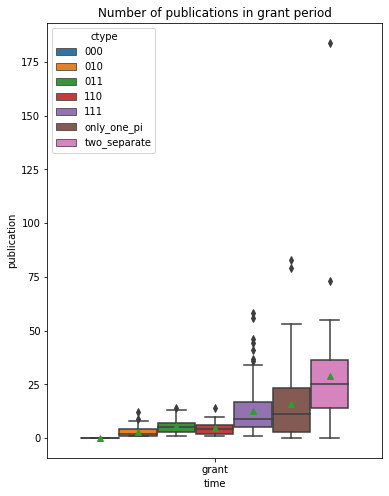

In [29]:
x = ["grant"]
ctype = ["000", "010", "011", "110", "111", "only_one_pi", "two_separate"]
box_plot_data = pd.DataFrame({
    "time": [time for time in x for k, v in collab_type.items() if v in ctype],
    "grant_amount": [dict_amount[k] for k, v in collab_type.items() if v in ctype],
    "grant_period": [dict_period[k] for k, v in collab_type.items() if v in ctype],
    "avg_team": [dict_teams[k][time]/dict_publications[k][time] if dict_publications[k][time] > 0 else 0 for time in x for k, v in collab_type.items() if v in ctype],
    "publication": [dict_publications[k][time] for time in x for k, v in collab_type.items() if v in ctype],
    "citation": [dict_citations[k][time] for time in x for k, v in collab_type.items() if v in ctype],
    "ctype": [v for time in x for k, v in collab_type.items() if v in ctype]
})
        
# print(box_plot_data.head(5))
plt.figure(figsize=(6,8))
ax = sns.boxplot(x="time", y="publication", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype).set_title("Number of publications in grant period")

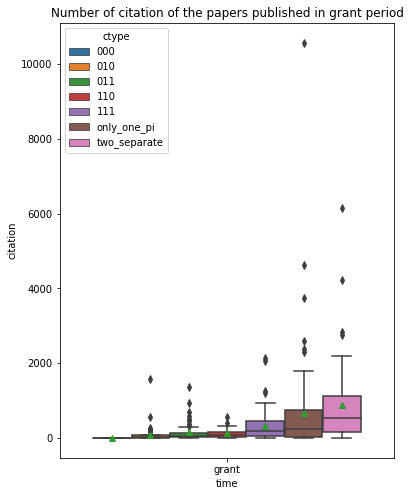

In [30]:
plt.figure(figsize=(6,8))
ax = sns.boxplot(x="time", y="citation", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype).set_title("Number of citation of the papers published in grant period")

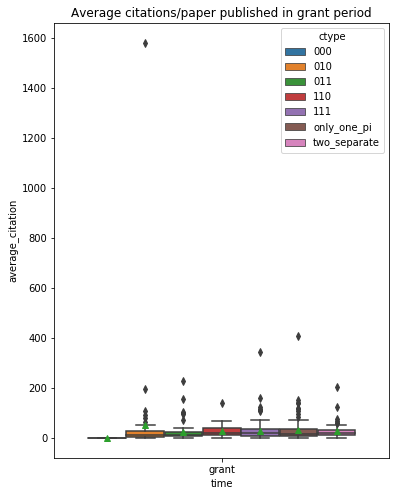

In [31]:
box_plot_data["average_citation"] = (box_plot_data["citation"]/box_plot_data["publication"]).fillna(0)
plt.figure(figsize=(6,8))
ax = sns.boxplot(x="time", y="average_citation", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype).set_title("Average citations/paper published in grant period")

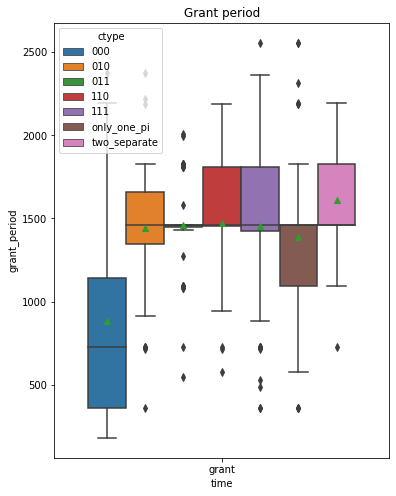

In [32]:
plt.figure(figsize=(6,8))
ax = sns.boxplot(x="time", y="grant_period", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype).set_title("Grant period")

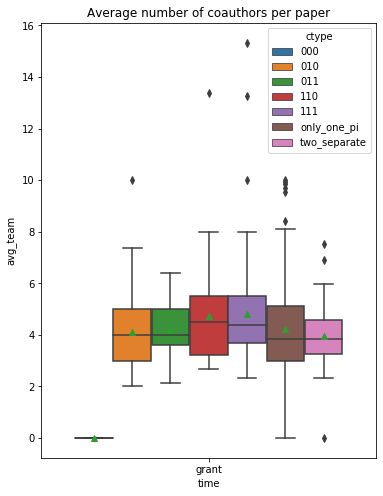

In [33]:
plt.figure(figsize=(6,8))
ax = sns.boxplot(x="time", y="avg_team", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype).set_title("Average number of coauthors per paper")

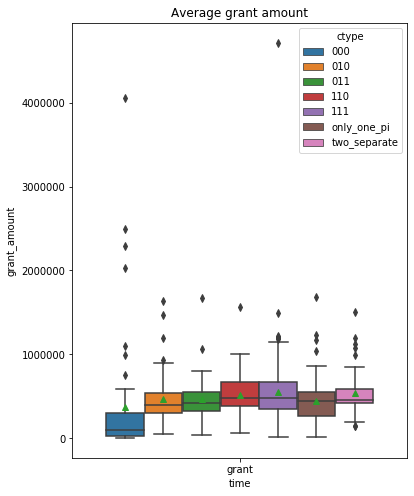

In [34]:
plt.figure(figsize=(6,8))
ax = sns.boxplot(x="time", y="grant_amount", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype).set_title("Average grant amount")